# CONVOLUTIONAL NEURAL NETWORK MODEL

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import time, sys, json, warnings

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, GlobalAveragePooling1D
from keras.losses import mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# Assuming you have a GPU, set the device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import seaborn as sns
import matplotlib.pyplot as plt

## 0) FUNCTIONS USED

In [2]:
# Split the sequence into samples
def split_sequences(sequences, n_steps): # Sequences is the dataset as 2d (X and Y) and n_steps the window for predicting next value
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Custom loss function to penalize scores outside (0,1)
def custom_loss(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE), same units as our data
    rmse = tf.sqrt(mse)   

    # Apply a penalty if values are outside the desired range (0, 1)
    lower_bound_penalty = tf.maximum(0.0, y_pred - 1.0)
    upper_bound_penalty = tf.maximum(0.0, -y_pred)

    penalty_factor = 100.0  

    total_loss = rmse + penalty_factor * (lower_bound_penalty + upper_bound_penalty)

    return total_loss

def reshape_sequence(sequence):
    """Reshape an array to have it in one column
    and the number of rows of its length (time series)"""
    return sequence.reshape((len(sequence), 1))

def get_additional_features(patient_data):
    """Extract additional features that are not variable for a patient."""
    preescolar = patient_data['age_Preescolar(0-5)'].iloc[0]
    children = patient_data['age_Children(6-11)'].iloc[0]
    teenager = patient_data['age_Teenagers(12-18)'].iloc[0]
    young_adult = patient_data['age_Young Adults(19-34)'].iloc[0]
    middle_adult = patient_data['age_Middle-Aged Adults(35-64)'].iloc[0]
    senior_adult = patient_data['age_Senior Adults(>65)'].iloc[0]
    gender = patient_data['gender'].iloc[0]

    return np.array([[gender, preescolar, children, teenager, young_adult, middle_adult, senior_adult]] * len(patient_data))

# CNN MODEL
def create_and_compile_CNN(params, n_steps, n_features):
    model = Sequential()

    if params['num_CNN_layers'] == 1:
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
        model.add(GlobalAveragePooling1D())
        
    elif params['num_CNN_layers'] == 2:
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
        model.add(GlobalAveragePooling1D())
    
    elif params['num_CNN_layers'] == 3:
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
        model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
        model.add(GlobalAveragePooling1D())

    # Add dropout if specified
    if params['dropout_rate'] > 0:
        model.add(Dropout(params['dropout_rate']))
    
    model.add(Dense(30, activation=params['activation']))

    # Add the output layer
    model.add(Dense(1))

    # optimizer
    optimizer = Adam(learning_rate=params['learning_rate'])

    # Compile the model with the selected optimizer and loss function
    model.compile(optimizer=optimizer, loss=custom_loss)

    return model


def print_progress_bar(iteration, total, bar_length=50):
    percent = "{0:.1f}".format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f"\rProgress: |{bar}| {percent}% Complete")
    sys.stdout.flush()

def js_r(json_file):
    with open(json_file) as json_file:
        dict_file = json.load(json_file)
    return dict_file

## 1) TIME SERIES DATA PREPARATION FOR LSTM MODEL

###### We have a **multivariate** (more than one feature) **multistep** (we want to predict more than one day) **non-parallel** (just predict one output variable) structure. To prepare our data, we need to:

- Transform the time series dataset into a two-dimensional supervised learning format
- Transform the two-dimensional data into a three-dimensional structure for MLP, LSTM and CNN.

In [3]:
series = pd.read_csv("../data/model_data01.csv")
series.head()

,patient_id,week,score,gender,Attention,Executive Functions,Gnosis,Language,Memory,Visuospatial Skills,age_Preescolar(0-5),age_Children(6-11),age_Teenagers(12-18),age_Young Adults(19-34),age_Middle-Aged Adults(35-64),age_Senior Adults(>65),age_group,combined_target
0,5e3175d5,01-2016,0.5833,2,0.584338,0.583300,0.458823,0.590329,0.629467,0.380805,0,0,0,0,1,0,5,2_5
1,5e3175d5,01-2021,0.3310,2,0.331078,0.331000,0.519627,0.331000,0.228763,0.372512,0,0,0,0,1,0,5,2_5
2,5e3175d5,02-2017,0.9820,2,0.982000,0.783395,0.648470,0.790198,0.824775,0.411100,0,0,0,0,1,0,5,2_5
3,5e3175d5,02-2019,0.3875,2,0.386652,0.387500,0.469652,0.381261,0.175828,0.377389,0,0,0,0,1,0,5,2_5
4,5e3175d5,02-2020,0.5282,2,0.528377,0.528200,0.479586,0.528200,0.547278,0.387961,0,0,0,0,1,0,5,2_5


In [4]:
unique_patients = series['patient_id'].unique()
patient_datasets = {}
n_steps = 2  # window size

for patient_id in unique_patients:
    patient_data = series[series['patient_id'] == patient_id]

    additional_features = get_additional_features(patient_data)

    sequences = [
        'Attention', 'Executive Functions', 'Gnosis', 
        'Language', 'Memory', 'Visuospatial Skills']

    in_sequences = [reshape_sequence(patient_data[seq].values) for seq in sequences]

    out_seq = reshape_sequence(patient_data['score'].values)

    if len(in_sequences[0]) >= n_steps:  # Assuming all sequences have the same length
        # Combine all sequences along with additional features
        combined_data = np.hstack((additional_features, *in_sequences, out_seq))

        # Split time series into samples
        X, y = split_sequences(combined_data, n_steps)

        # Convert to float
        X = X.astype(float)
        y = y.astype(float)

        # Reshape data for CNN architecture
        n_features = 7 + len(sequences) # 7 = 6 age groups + gender
        X = X.reshape((X.shape[0], n_steps, n_features)) 

        # Save data for each patient
        patient_datasets[patient_id] = {'X': X, 'y': y}
        

In [6]:
patient_datasets['003ccc87']['X'][0]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.48556667, 0.603     , 0.44506667,
        0.63653333, 0.48655   , 0.5088    ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.51993333, 0.4875    , 0.6       ,
        0.535     , 0.7887    , 0.67536667]])

## 2) TIME SERIES CROSS VALIDATION AND GRID SEARCH

In [7]:
# Time series cross validation and grid search

# Define the hyperparameter grid
param_grid = {
    'num_layers': [1, 2, 3],  # Number of  hidden layer(s)
    'num_CNN_layers': [1, 2, 3], # Number of CNN layers
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate for the optimizer
    'activation': ['relu', 'selu', 'tanh'],   # Activation function for hidden layers
    'dropout_rate': [0, 0.05, 0.1],  # Dropout rate to use, if any (regularization technique)
}

grid = ParameterGrid(param_grid)

n_splits = 2

# cross validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create a dictionary to store average loss for each parameter combination
val_loss_by_patient = {}

# Store models
params_dict = {}

chunk0 = unique_patients[:100]
chunk1 = unique_patients[:311]
chunk2 = unique_patients[311:622]
chunk3 = unique_patients[622:933]
chunk4 = unique_patients[933:1244]

In [8]:
# Track progress
total_iterations = len(chunk0)
total_total_iterations = len(grid) * len(chunk0)
iteration_count = 0
start_time = time.time()

print("STARTING HYPERPARAMETER TUNING: \n")
for model_number,params in enumerate(grid):
    print(f"\n\nModel {model_number+1} / {len(grid)} training\n")
    params_dict [model_number +1] = str(params)
    model = create_and_compile_CNN(params, n_steps, n_features)

    for index, patient_id in enumerate(chunk0, start=1):
        sys.stdout.write("\r")  # Move cursor to the beginning of the line
        sys.stdout.write(f"STARTING CHUNK {index} / {total_iterations}")
        sys.stdout.flush()

        data = patient_datasets[patient_id]
        X, y = data['X'], data['y']

        # Split data
        split_index1 = int(0.6 * len(X))
        split_index2 = int(0.8 * len(X))
        X_train, X_val, _ = X[:split_index1], X[split_index1:split_index2], X[split_index2:]
        y_train, y_val, _ = y[:split_index1], y[split_index1:split_index2], y[split_index2:]

        val_loss_list = [] # List to store validation loss

        try:
          for train_index, val_index in tscv.split(X_train):
              X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
              y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

              # Train model
              model.fit(X_train_fold, y_train_fold,epochs=40, verbose=0)

              # Evaluate on validation set
              val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
              val_loss_list.append(val_loss)

        except ValueError:
          # Handle patients where Time SeriesSplit cannot be performed
          continue
          # print(f"\nSkipping patient {patient_id} due to insufficient data for TimeSeriesSplit")

        if len(val_loss_list) != 0:
          val_loss_by_patient[(model_number +1, patient_id)] = val_loss_list

        iteration_count += 1
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
        remaining_iterations = total_iterations - iteration_count
        estimated_remaining_time = remaining_iterations * avg_time_per_iteration
        print_progress_bar(iteration_count, total_total_iterations)

print("\n")
print("HYPERPARAMETER TUNING DONE")
print("\nSaving loss and model dictionaries...")

# Convert tuple keys to strings
val_loss_by_patient_str_keys = {str(key): value for key, value in val_loss_by_patient.items()}

# Save dictionary as a JSON file
with open('CNN_1val_loss_models.json', 'w') as f:
    json.dump(val_loss_by_patient_str_keys, f)

with open('CNN_models_dictionary.json', 'w') as f:
    json.dump(params_dict, f)

print("DONE, CHUNK FINISHED")

STARTING HYPERPARAMETER TUNING: 



Model 1 / 243 training


STARTING CHUNK 1 / 100WARNING:tensorflow:From C:\Users\PC\anaconda3\envs\TFM\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

Progress: |--------------------------------------------------| 0.4% Complete

Model 2 / 243 training

Progress: |--------------------------------------------------| 0.8% Complete

Model 3 / 243 training

Progress: |█-------------------------------------------------| 1.2% Complete

Model 4 / 243 training

Progress: |█-------------------------------------------------| 1.6% Complete

Model 5 / 243 training

Progress: |█-------------------------------------------------| 2.1% Complete

Model 6 / 243 training

Progress: |█-------------------------------------------------| 2.5% Complete

Model 7 / 243 training

Progress: |█-------------------------------------------------| 2.9% Complete

Model 8 / 

### 3) BEST HYPERPARAMETER CALCULATIONS FOR EACH SUBSET OF DATA

In [9]:
warnings.filterwarnings('ignore')

models_dict = js_r('CNN_models_dictionary.json')
# models_dict

# LOSS FOR EACH TIME SERIES SPLIT FOR EVERY PATIENT IN EVERY MODEL
patients_loss = js_r('CNN_1val_loss_models.json')
# patients_loss

# Calculate the mean for each list of values and update the dictionary
for patient, values in patients_loss.items():
    mean_value = sum(values) / len(values)
    patients_loss[patient] = mean_value

# Initialize an empty DataFrame
loss_df = pd.DataFrame()

# Iterate through the dictionary and add columns to the DataFrame
for key, values in patients_loss.items():
    model_number, patient_id = eval(key)
    
    # Create a new column if it doesn't exist
    if f'model{model_number}' not in loss_df.columns:
        loss_df[f'model{model_number}'] = pd.Series(dtype=float)
    
    # Add the value to the corresponding column and row
    loss_df.at[patient_id, f'model{model_number}'] = values

# Reset the index to have 'patient_id' as a column
loss_df = loss_df.reset_index()
loss_df = loss_df.set_index('index')

In [10]:
loss_df


,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model234,model235,model236,model237,model238,model239,model240,model241,model242,model243
index,,,,,,,,,,,,,,,,,,,,,
5e3175d5,0.181650,0.034989,0.125614,0.029498,0.025419,0.232372,0.041144,0.047795,0.054408,0.132168,...,0.102185,0.299860,0.161135,0.153394,0.171609,0.292348,0.187387,0.204343,0.172590,0.400108
c26d1d59,0.200881,0.269938,0.131069,0.056679,0.128119,0.153943,0.125103,0.643709,0.064314,0.144295,...,0.171262,0.186956,0.182912,0.187133,0.181318,0.180079,0.179801,0.159958,0.179745,0.445535
fdedd3cc,0.093271,0.044460,0.085067,0.040547,0.037787,0.058473,0.047542,0.044461,0.117329,0.117901,...,0.300885,0.284235,0.160980,0.162132,60.415045,0.161381,0.161835,9.072563,0.164183,0.348089
e99dae7a,0.054530,0.068239,0.069243,0.032824,0.017443,0.026581,0.027731,0.027280,0.080239,0.037819,...,0.198861,0.223187,0.218196,0.218534,12.587101,0.217404,0.218360,12.430778,0.217851,0.430324
de4688b0,0.109091,0.110168,0.101785,0.085930,0.086190,0.086697,0.087705,0.090771,0.095329,0.090647,...,0.106732,0.140569,0.142598,0.140856,12.524438,0.150872,0.142530,39.565243,0.139904,0.238746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59988ef9,0.113822,0.068329,0.130619,0.107200,0.124782,0.143812,0.154343,0.122469,0.128681,0.118403,...,0.196003,0.181548,0.179433,0.222898,0.190239,0.198725,0.179447,0.204975,0.194268,0.193047
c6e2ac19,0.049801,0.048998,0.047566,0.050508,0.049136,0.045699,0.051352,0.045451,0.043717,0.048654,...,0.119279,0.115725,0.119158,0.126143,0.121885,0.120816,0.128227,0.114728,0.133790,0.110400
6590557e,0.041445,0.044292,0.045218,0.033507,0.036658,0.032434,0.057271,0.007915,0.046439,0.036844,...,0.179998,0.215088,0.221788,4.068407,0.223883,0.217033,0.180785,0.181581,0.234578,0.214122


In [11]:
loss_df.columns[loss_df.isna().any()].tolist()



['model51',
 'model60',
 'model61',
 'model80',
 'model86',
 'model87',
 'model108',
 'model144',
 'model166',
 'model169',
 'model174',
 'model186',
 'model202',
 'model218',
 'model221',
 'model231',
 'model233']

In [12]:
models_dict

{'1': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 1, 'num_layers': 1}",
 '2': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 1, 'num_layers': 2}",
 '3': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 1, 'num_layers': 3}",
 '4': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 2, 'num_layers': 1}",
 '5': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 2, 'num_layers': 2}",
 '6': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 2, 'num_layers': 3}",
 '7': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 3, 'num_layers': 1}",
 '8': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 3, 'num_layers': 2}",
 '9': "{'activation': 'relu', 'dropout_rate': 0, 'learning_rate': 0.001, 'num_CNN_layers': 3, 'n

#### 3.1) ACTIVATION FUNCTION

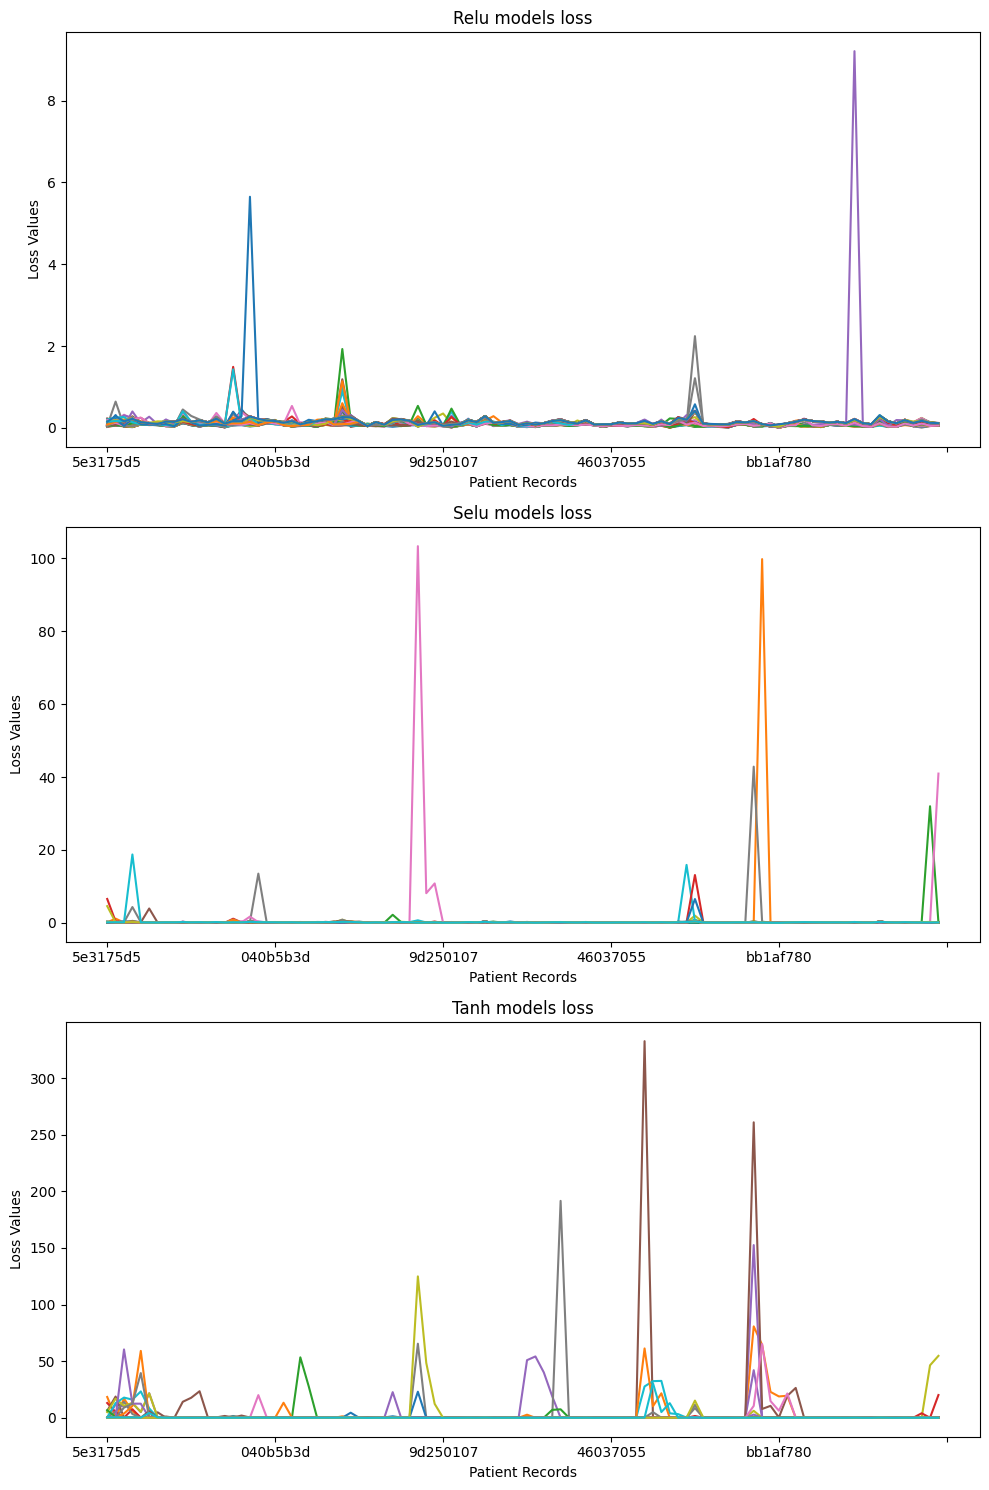

In [13]:
# Define the ranges for different activation functions
activation_ranges = [(0, 81), (82, 162), (163, 243)]
activation_names = ['Relu models loss', 'Selu models loss', 'Tanh models loss']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each activation range
for i, (start_idx, end_idx) in enumerate(activation_ranges):
    # Extract the relevant columns for the current activation range
    subset_df = loss_df.iloc[:, start_idx:end_idx]

    # if i == 1:
        # subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
    
    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)
    
    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(activation_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
# for ax in axes:
#     ax.set_ylim(0, 0.5)

# axes[1].set_ylim(0,5)
# axes[2].set_ylim(0,5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

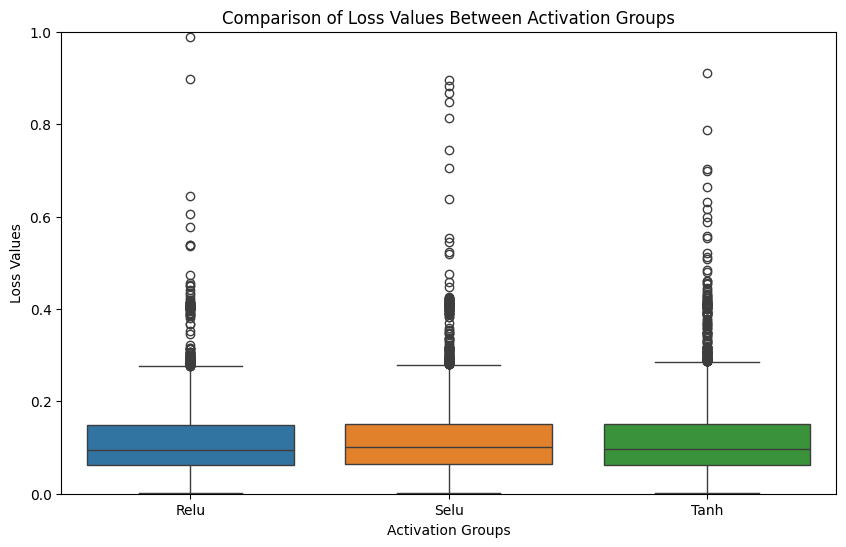

In [14]:
# Define the ranges for different activation functions
activation_ranges = [(0, 81), (82, 162), (163, 243)]
activation_names = ['Relu', 'Selu', 'Tanh']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each activation range
for start_idx, end_idx in activation_ranges:
    # Extract the relevant columns for the current activation range
    subset_df = loss_df.iloc[:, start_idx:end_idx]

    # if i == 1:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
        
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

plt.xticks(ticks=[0, 1, 2], labels=activation_names)

# Set a maximum value for the y-axis
plt.ylim(0, 1)  # Replace 'your_maximum_value' with the desired value

plt.xlabel('Activation Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Activation Groups')

# Show the plot
plt.show()

#### 3.2) NUMBER OF CNN LAYERS

In [15]:
i = 0
cnn_layer_range1 = []
cnn_layer_range2 = []
cnn_layer_range3 = []

while i < 235:
    cnn_layer_range1.extend([i, i+1, i+2])
    cnn_layer_range2.extend([i+3, i+4, i+5])
    cnn_layer_range3.extend([i+6, i+7, i+8])
    i += 9

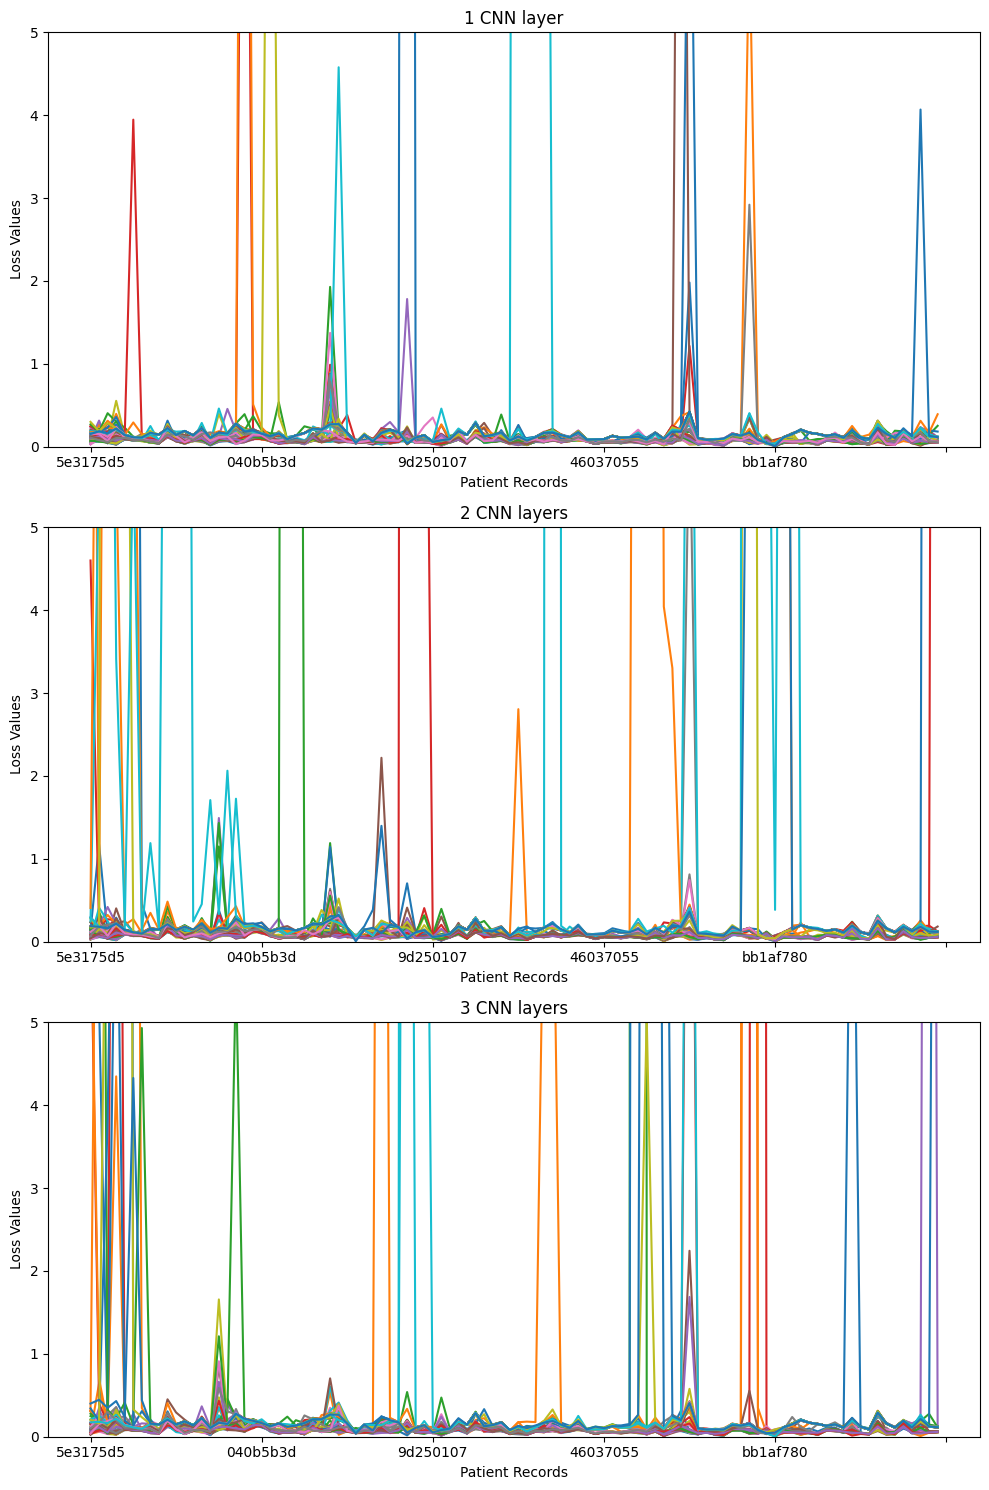

In [16]:
# Define the ranges for different activation functions
cnn_layers_ranges = [cnn_layer_range1, cnn_layer_range2, cnn_layer_range3]
cnn_layers_names = ['1 CNN layer', '2 CNN layers', '3 CNN layers']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each activation range
for i, indices in enumerate(cnn_layers_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(cnn_layers_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
for ax in axes:
    ax.set_ylim(0, 5)

# axes[1].set_ylim(0,5)
# axes[2].set_ylim(0,5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

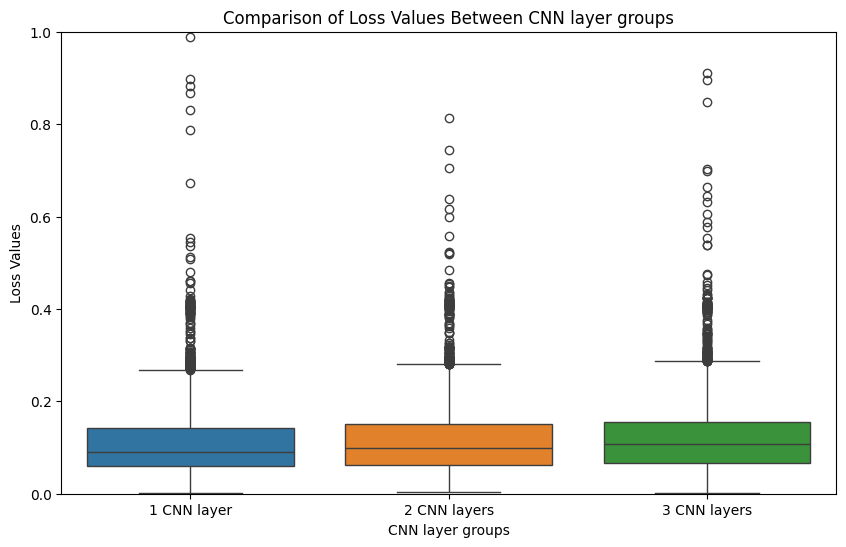

In [17]:
cnn_layers_ranges = [cnn_layer_range1, cnn_layer_range2, cnn_layer_range3]
cnn_layers_names = ['1 CNN layer', '2 CNN layers', '3 CNN layers']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each lr range
for i, indices in enumerate(cnn_layers_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(cnn_layers_names)), labels=cnn_layers_names)

# Max y value
plt.ylim(0, 1)  

plt.xlabel('CNN layer groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between CNN layer groups')

# Show the plot
plt.show()

#### 3.3) NUMBER OF DENSE LAYERS

In [18]:
i = 0
layer_range1 = []
layer_range2 = []
layer_range3 = []

while i < 241:
    layer_range1.append(i)
    layer_range2.append(i+1)
    layer_range3.append(i+2)
    i += 3

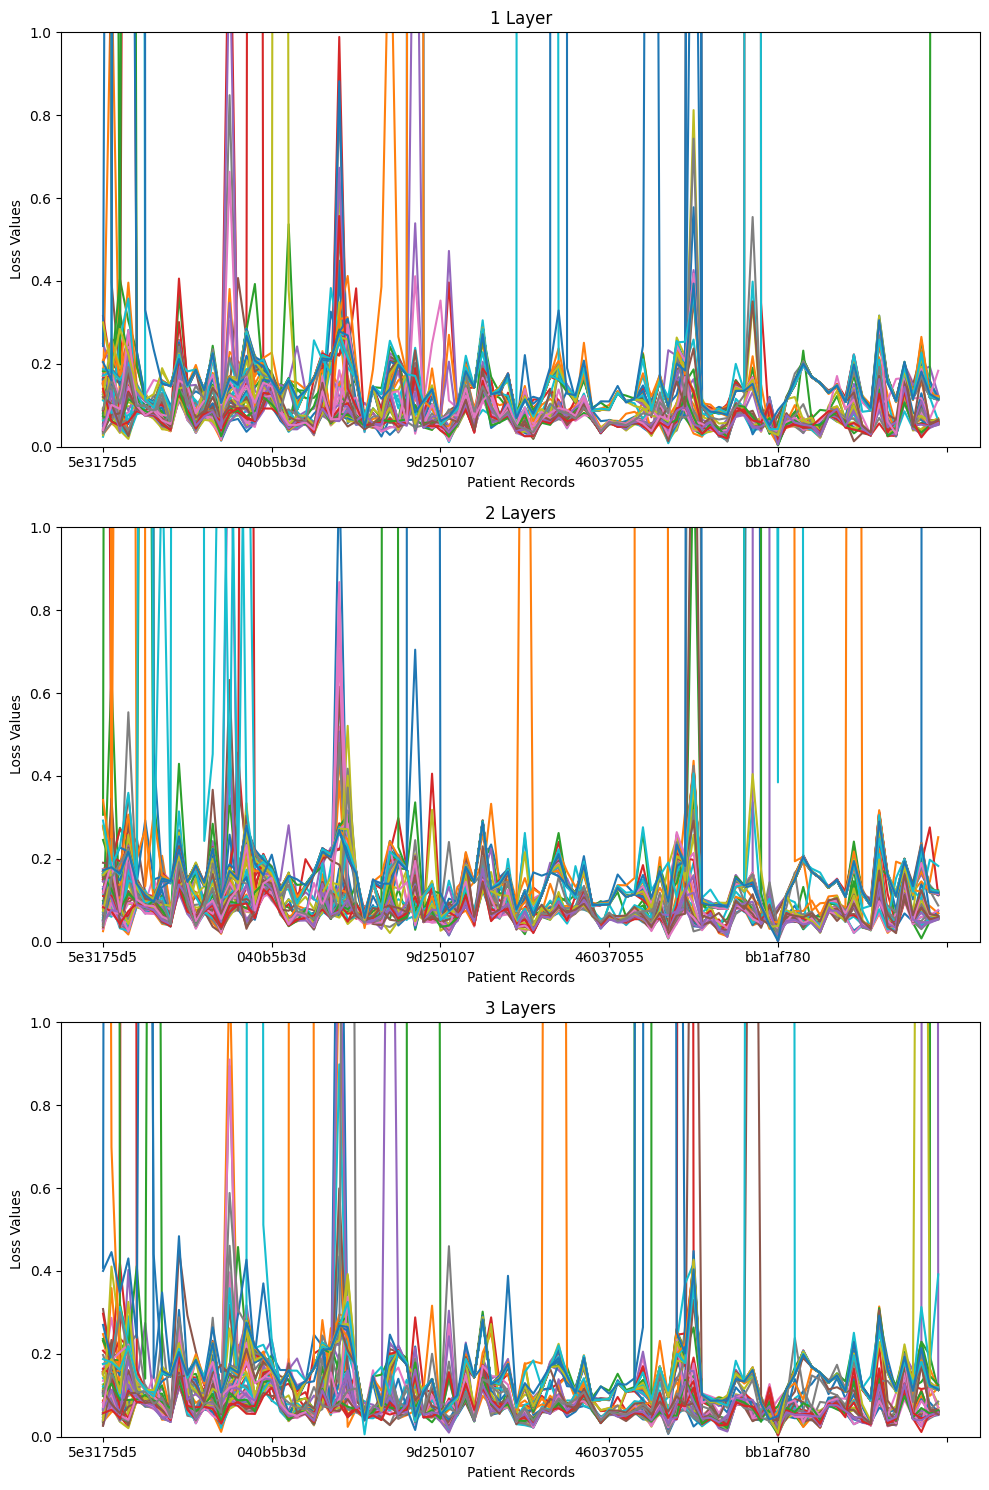

In [19]:
layer_ranges = [layer_range1, layer_range2, layer_range3]
layer_names = ['1 Layer', '2 Layers', '3 Layers']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(layer_ranges):        
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop('model52', axis=1)
    # elif i == 1:
    #     subset_df = subset_df.drop('model35', axis=1)
    # else:
    #     subset_df = subset_df.drop(['model36', 'model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(layer_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
for ax in axes:
    ax.set_ylim(0, 1)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

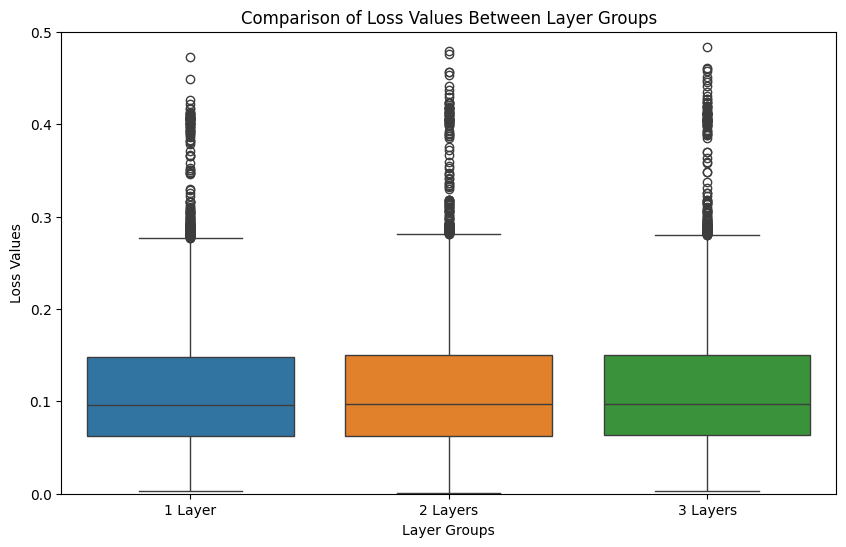

In [20]:
layer_ranges = [layer_range1, layer_range2, layer_range3]
layer_names = ['1 Layer', '2 Layers', '3 Layers']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each layer range
for i, indices in enumerate(layer_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop('model52', axis=1)
    # elif i == 1:
    #     subset_df = subset_df.drop('model35', axis=1)
    # else:
    #     subset_df = subset_df.drop(['model36', 'model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(layer_names)), labels=layer_names)

# Max y value
plt.ylim(0, 0.5)  

plt.xlabel('Layer Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Layer Groups')

# Show the plot
plt.show()

#### 3.4) LEARNING RATE

In [21]:
i = 0
lr_range1 = []
lr_range2 = []
lr_range3 = []

while i < 241:
    lr_range1.extend([i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8])
    lr_range2.extend([i+9, i+10, i+11, i+12, i+13, i+14, i+15, i+16, i+17])
    lr_range3.extend([i+18, i+19, i+20, i+21, i+22, i+23, i+24, i+25, i+26])
    i += 27

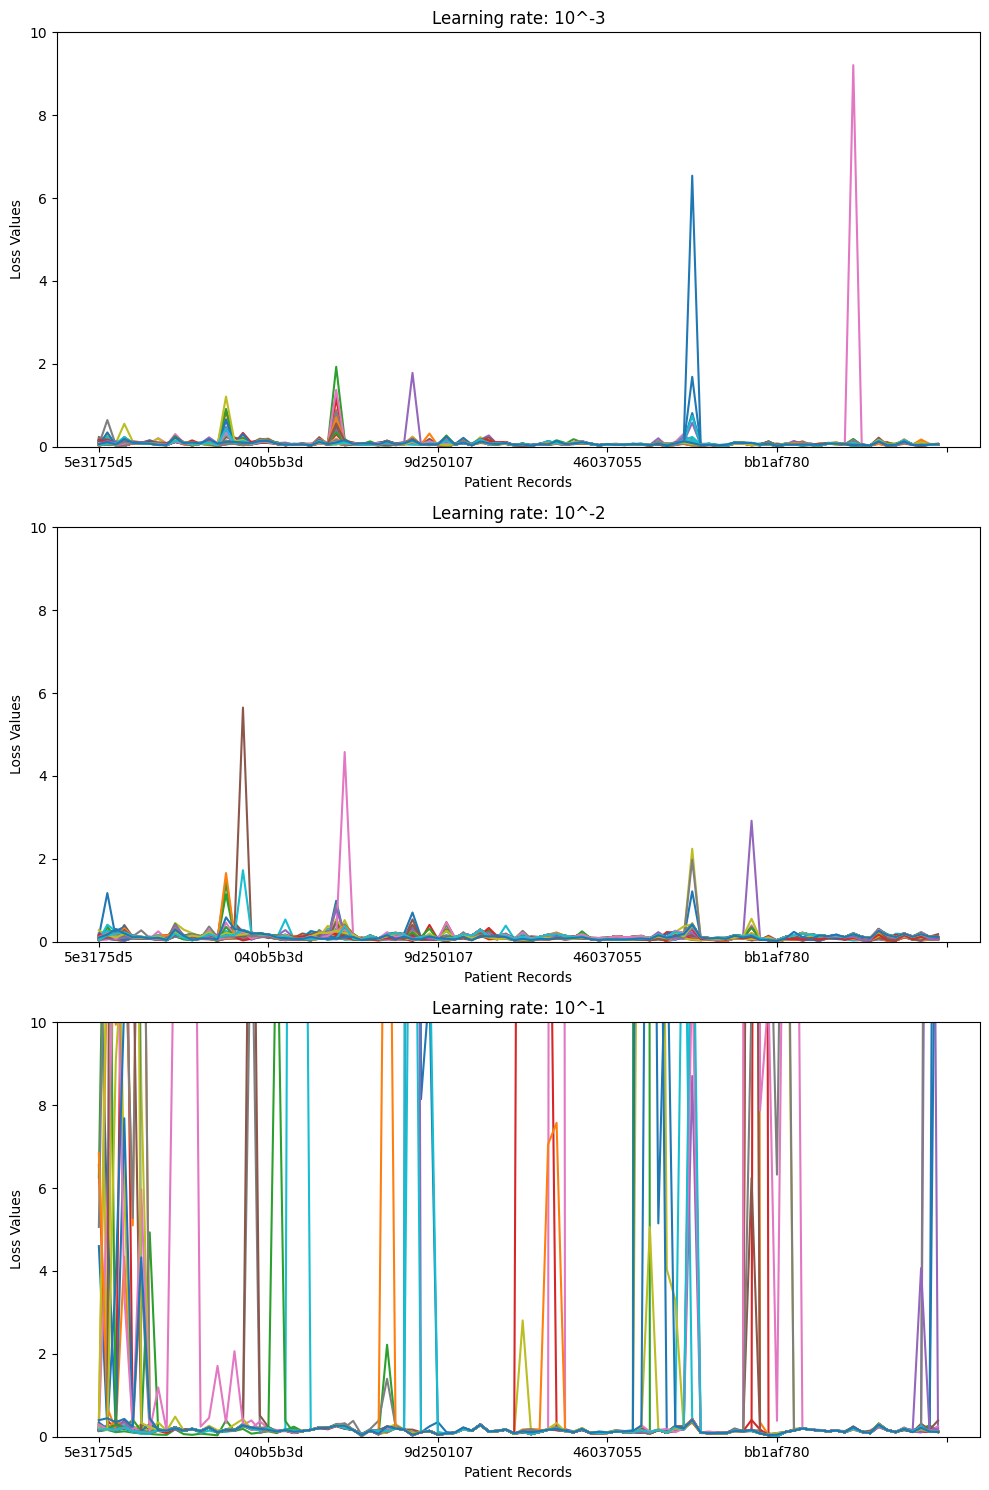

In [22]:
lr_ranges = [lr_range1, lr_range2, lr_range3]
lr_names = ['Learning rate: 10^-3', 'Learning rate: 10^-2', 'Learning rate: 10^-1']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(lr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(lr_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
for ax in axes:
    ax.set_ylim(0, 10)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

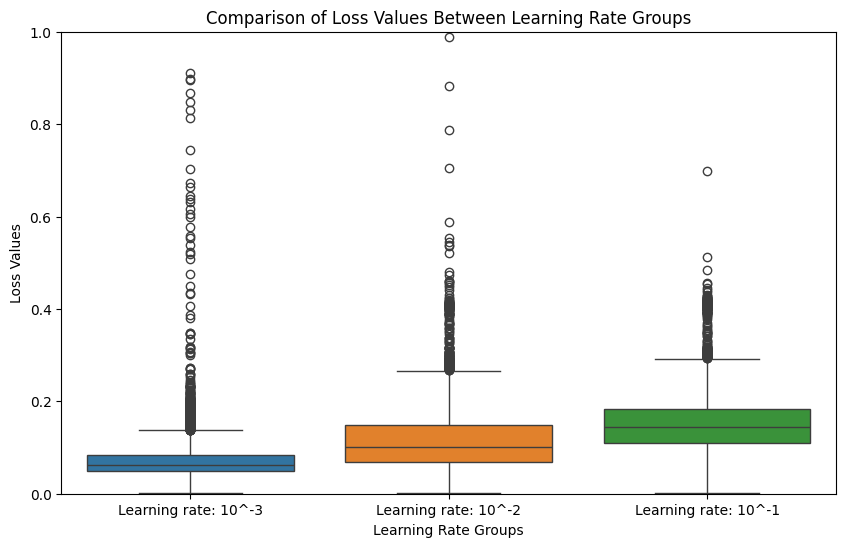

In [23]:
lr_ranges = [lr_range1, lr_range2, lr_range3]
lr_names = ['Learning rate: 10^-3', 'Learning rate: 10^-2', 'Learning rate: 10^-1']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each lr range
for i, indices in enumerate(lr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(lr_names)), labels=lr_names)

# Max y value
plt.ylim(0, 1)  

plt.xlabel('Learning Rate Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Learning Rate Groups')

# Show the plot
plt.show()

#### 3.5) DROPOUT RATE

In [24]:
i = 0
dr_range1 = []
dr_range2 = []
dr_range3 = []

while i < 240:
    dr_range1.extend([i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8, i+9, i+10, i+11, i+12, i+13, i+14, i+15, i+16, i+17, i+18, i+19, i+20, i+21, i+22, i+23, i+24, i+25, i+26])
    dr_range2.extend([i+27, i+28, i+29, i+30, i+31, i+32, i+33, i+34, i+35,i+36, i+37, i+38, i+39, i+40, i+41, i+42, i+43, i+44,i+45, i+46, i+47, i+48, i+49, i+50, i+51, i+52, i+53])
    dr_range3.extend([i+54, i+55, i+56, i+57, i+58, i+59, i+60, i+61, i+62, i+63, i+64, i+65, i+66, i+67, i+68, i+69, i+70, i+71,i+72, i+73, i+74, i+75, i+76, i+77, i+78, i+79, i+80])
    i += 81

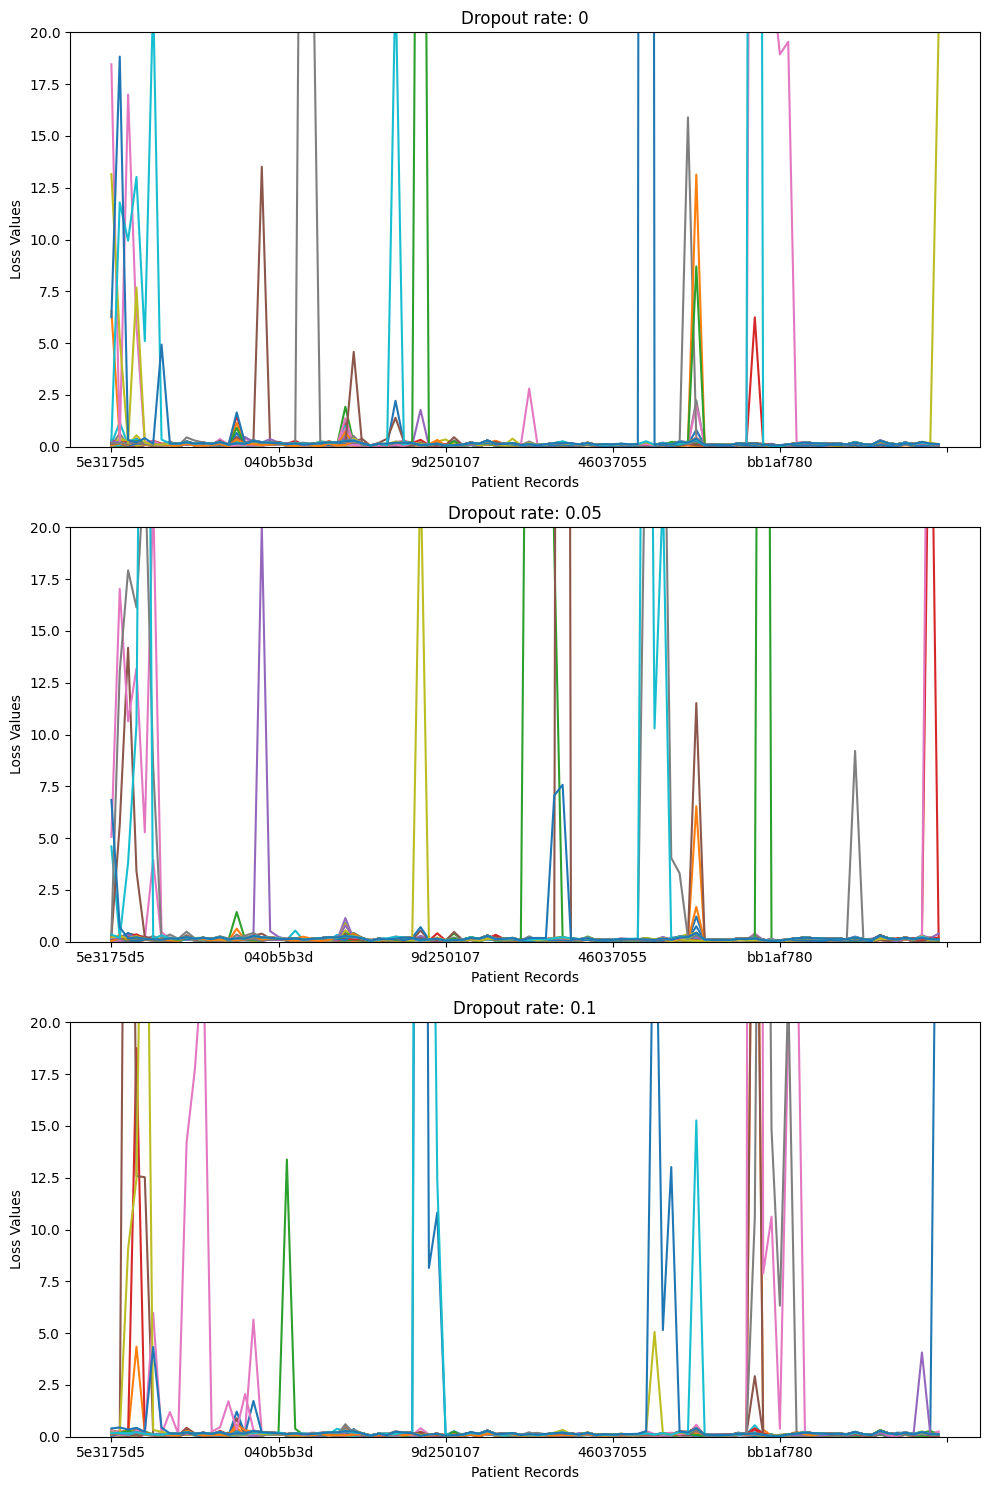

In [25]:
dr_ranges = [dr_range1, dr_range2, dr_range3]
dr_names = ['Dropout rate: 0', 'Dropout rate: 0.05', 'Dropout rate: 0.1']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(dr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop(['model35','model36'], axis=1)
    # elif i == 2:
    #     subset_df = subset_df.drop(['model52','model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(dr_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# Maximum y value to make zoom into the plot
for ax in axes:
    ax.set_ylim(0, 20)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

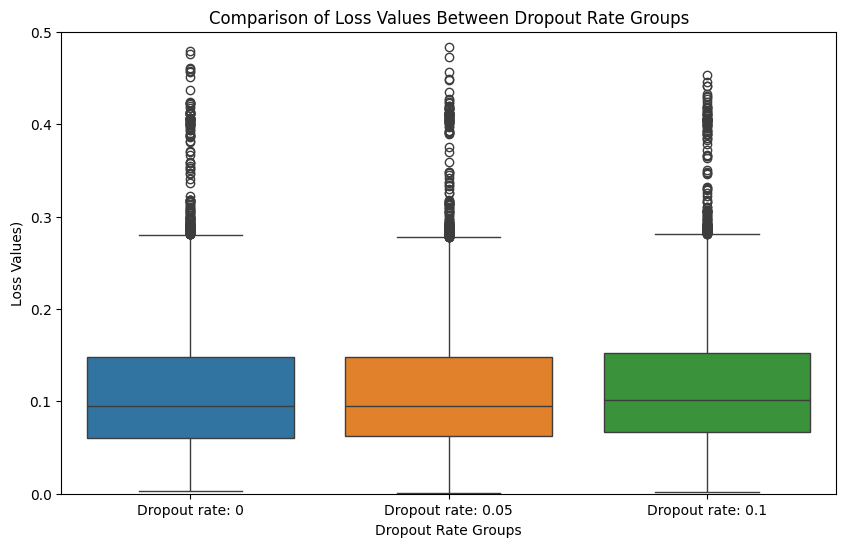

In [26]:
dr_ranges = [dr_range1, dr_range2, dr_range3]
dr_names = ['Dropout rate: 0', 'Dropout rate: 0.05', 'Dropout rate: 0.1']


# Create an empty list to store the data for each group
group_data = []

# Iterate through each lr range
for i, indices in enumerate(dr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop(['model35','model36'], axis=1)
    # elif i == 2:
    #     subset_df = subset_df.drop(['model52','model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(dr_names)), labels=dr_names)

# Max y value
plt.ylim(0, 0.5)  

plt.xlabel('Dropout Rate Groups')
plt.ylabel('Loss Values)')
plt.title('Comparison of Loss Values Between Dropout Rate Groups')

# Show the plot
plt.show()

- **Relu** activation function seems more constant, and doesn't have high outliers.

- **CNN Layers** as 1 layer with best performance.

- **Layers** with no difference, so we choose 1 for computational efficiency.

- **Learning rate** of 10^-3 seems more constant.

- **Dropout rate** with no important differences... We choose 0 for simplicity.

### 4) MODEL PREDICTIONS ON TEST SET

In [3]:
series = pd.read_csv("data/model_data2.csv")
series.head()

,patient_id,week,score,gender,Alternating Attention,Attention,Auditory Gnosis,Body Schema,Comprehension,Decision Making,...,Working M.,Writing,age_Preescolar(0-5),age_Children(6-11),age_Teenagers(12-18),age_Young Adults(19-34),age_Middle-Aged Adults(35-64),age_Senior Adults(>65),age_group,combined_target
0,00398d27,2017-03-06,0.8404,1,0.0,0.8170,0.0,0.0,0.0,0.0,...,0.8900,0.0,0,0,0,0,0,1,6,1_6
1,00398d27,2017-08-21,0.6844,1,0.0,0.6254,0.0,0.0,0.0,0.0,...,0.6373,0.0,0,0,0,0,0,1,6,1_6
2,00398d27,2017-09-04,0.1181,1,0.0,0.1150,0.0,0.0,0.0,0.0,...,0.1250,0.0,0,0,0,0,0,1,6,1_6
3,00398d27,2017-09-18,0.1168,1,0.0,0.1360,0.0,0.0,0.0,0.0,...,0.0900,0.0,0,0,0,0,0,1,6,1_6
4,00398d27,2017-09-25,0.4326,1,0.0,0.5612,0.0,0.0,0.0,0.0,...,0.2568,0.0,0,0,0,0,0,1,6,1_6


In [42]:
unique_patients = series['patient_id'].unique()
unique_patients = unique_patients[0:1000]

patient_datasets = {}
n_steps = 2  # window size

for patient_id in unique_patients:
    patient_data = series[series['patient_id'] == patient_id]

    additional_features = get_additional_features(patient_data)

    sequences = [
        'Attention', 'Executive Functions', 'Gnosis', 
        'Language', 'Memory', 'Visuospatial Skills']

    in_sequences = [reshape_sequence(patient_data[seq].values) for seq in sequences]

    out_seq = reshape_sequence(patient_data['score'].values)

    if len(in_sequences[0]) >= n_steps:  # Assuming all sequences have the same length
        # Combine all sequences along with additional features
        combined_data = np.hstack((additional_features, *in_sequences, out_seq))

        # Split time series into samples
        X, y = split_sequences(combined_data, n_steps)

        # Convert to float
        X = X.astype(float)
        y = y.astype(float)

        # Reshape data for RNN architecture
        n_features = 7 + len(sequences) # 7 = 6 age groups + gender
        X = X.reshape((X.shape[0], n_steps, n_features)) 
        
        # Save data for each patient
        patient_datasets[patient_id] = {'X': X, 'y': y}

In [ ]:
# unique_patients = np.delete(unique_patients, 1150)

In [44]:
# Track progress
total_iterations = len(unique_patients)
iteration_count = 0
start_time = time.time()

# Saving test data
predictions_by_patient = {}

# Set a random seed for reproducibility
tf.random.set_seed(42)

model = Sequential()
# Add a CNN layer
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
model.add(GlobalAveragePooling1D())
# Add a hidden layer with the specified parameters
model.add(Dense(30, activation='relu',))
model.add(Dropout(0.05))
# Add the output layer
model.add(Dense(1))
#optimizer
optimizer = Adam(learning_rate=0.001)
# Compile the model with the selected optimizer and loss function
model.compile(optimizer=optimizer, loss=custom_loss)

for index, patient_id in enumerate(unique_patients, start=1):
    # sys.stdout.write("\r")  # Move cursor to the beginning of the line
    # sys.stdout.write(f"STARTING CHUNK EVALUATION IN PATIENT {index} / {len(unique_patients)} \n")
    # sys.stdout.flush()

    data = patient_datasets[patient_id]
    X, y = data['X'], data['y']

    # Ensure that there are at least 20 data points for training and 10 for testing
    if len(X) >= 30:
        # Extract the last 10 data points for the test set and the previous 20 for the training set
        X_train, y_train = X[-30:-10], y[-30:-10]
        X_test, y_test = X[-10:], y[-10:]
    
        # Train the model on patient-specific data
        model.fit(X_train, y_train, epochs=40, verbose=0)
    
        # Make predictions on the test set
        predictions = model.predict(X_test, verbose=0)
    else:
        iteration_count += 1
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
        remaining_iterations = total_iterations - iteration_count
        estimated_remaining_time = remaining_iterations * avg_time_per_iteration
    
        # Create dynamic progress update string
        progress_update = f"PROGRESS: {iteration_count}/{total_iterations} - Elapsed Time: {elapsed_time:.2f}s - Estimated Remaining Time: {estimated_remaining_time:.2f}s"
    
        # Print dynamic progress update
        sys.stdout.write("\r" + " " * len(progress_update))  # Clear the previous line
        sys.stdout.write("\r" + progress_update)  # Print the dynamic progress update
        sys.stdout.flush()
        continue

     # Save predictions for later analysis
    predictions_by_patient[patient_id] = {'predictions': predictions, 'true_values': y_test}

    iteration_count += 1
    elapsed_time = time.time() - start_time
    avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
    remaining_iterations = total_iterations - iteration_count
    estimated_remaining_time = remaining_iterations * avg_time_per_iteration

    # Create dynamic progress update string
    progress_update = f"PROGRESS: {iteration_count}/{total_iterations} - Elapsed Time: {elapsed_time:.2f}s - Estimated Remaining Time: {estimated_remaining_time:.2f}s"

    # Print dynamic progress update
    sys.stdout.write("\r" + " " * len(progress_update))  # Clear the previous line
    sys.stdout.write("\r" + progress_update)  # Print the dynamic progress update
    sys.stdout.flush()

print("\n")
print("PREDICTION ON TEST SET DONE")



PROGRESS: 1000/1000 - Elapsed Time: 651.24s - Estimated Remaining Time: 0.00ss

PREDICTION ON TEST SET DONE


In [46]:
# # Convert NumPy arrays to Python lists in the dictionary
# for key, value in predictions_by_patient.items():
#     value['predictions'] = value['predictions'].tolist()
#     value['true_values'] = value['true_values'].tolist()

# # Assuming your dictionary is named predictions_by_patient
# for patient_id, values in predictions_by_patient.items():
#     # Flatten the list of lists in 'predictions'
#     flattened_predictions = [item for sublist in values['predictions'] for item in sublist]
    
#     # Update the 'predictions' field with the flattened list
#     values['predictions'] = flattened_predictions
    
# # Save the dictionary as a JSON file
# with open('CNN_1000predictions_by_patient.json', 'w') as f:
#     json.dump(predictions_by_patient, f)

### 5) MODEL EVALUATION

#### 5.1) ERROR METRICS

In [47]:
rmse_dict = {}

for key, value in predictions_by_patient.items():
    pred = value['predictions']
    true = value['true_values']
    # Calculate RMSE
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    rmse_dict[key] = rmse

In [49]:
# #SAVE RMSE 
# # Convert NumPy arrays to Python lists in the dictionary
# for key, value in rmse_dict.items():
#     rmse_dict[key] = value.tolist()

#  # Save dictionary as a JSON file
# with open('CNN_1000_RMSE_predictions.json', 'w') as f:
#     json.dump(rmse_dict, f)

In [3]:
with open('CNN_1000_RMSE_predictions.json') as json_file:
    rmse_dict = json.load(json_file)

In [ ]:
np.where(unique_patients == 'be7e9924' ) 

In [5]:
# RMSE SUMMARY STATISTICS
all_rmse_values = list(rmse_dict.values())

mean_rmse = np.mean(all_rmse_values)
median_rmse = np.median(all_rmse_values)
std_rmse = np.std(all_rmse_values)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Median RMSE: {median_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

Mean RMSE: 0.0722
Median RMSE: 0.0613
Standard Deviation of RMSE: 0.0463


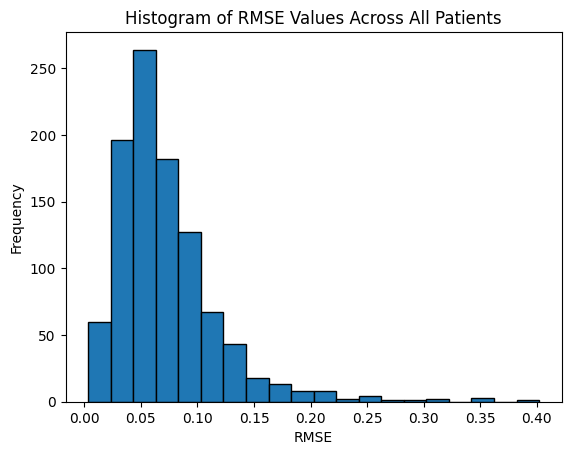

In [6]:
plt.hist(all_rmse_values, bins=20, edgecolor='black')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE Values Across All Patients')
plt.show()

#### 5.2) PERFORMANCE METRICS

In [7]:
with open('CNN_1000predictions_by_patient.json') as json_file:
    predictions_by_patient = json.load(json_file)

In [8]:
forecast_bias_dict = {}

for key, value in predictions_by_patient.items():
    predictions = value['predictions']
    true_values = value['true_values']

    # Calculate forecast differences
    differences = [predicted - actual for predicted, actual in zip(predictions, true_values)]

    # Calculate forecast bias
    bias = sum(differences) / len(differences)
    
    forecast_bias_dict[key] = bias

In [9]:
forecast_bias_dict

{'00398d27': 0.11357741718292236,
 '003bd8ad': -0.06454717214584352,
 '003ccc87': 0.0024534985762376203,
 '0073aba6': -0.07127916051546733,
 '00971dfc': -0.1277378474076589,
 '00c1eeab': -0.007787469315528872,
 '015572cd': -0.15172171540260312,
 '0158a9f3': 0.024056629873358687,
 '0167e529': -0.016221139780824824,
 '01b81d09': -0.1397229505221049,
 '01e9f82a': -0.08132527085410222,
 '0240182d': 0.0011234797763824355,
 '025c4baf': -0.026948079422245853,
 '02a66dbc': -0.0568891603410244,
 '02cf6d5f': -0.04414010053000799,
 '02ead9b7': -0.18090177643299102,
 '03261a54': 0.012972270147940697,
 '035959ee': 0.0066507917979708635,
 '0395b7da': -0.04695881945192813,
 '039760e1': -0.09728634649912517,
 '03a87410': 0.04777729492868697,
 '03ffa179': 0.02644550333023073,
 '04074dfe': -0.009770997393131253,
 '040ac6f7': 0.03537327458262443,
 '0436df3a': -0.0059885410785675,
 '0479573e': 0.10558426240285235,
 '057c2173': -0.005113502208391824,
 '057d56cb': 0.05190468918482464,
 '05bdf1da': -0.081445

In [10]:
# FORECAST BIAS SUMMARY STATISTICS
all_forecast_values = []
for value in forecast_bias_dict.values():
    if not np.isnan(value):
        all_forecast_values.append(value)

all_forecast_values = np.array(all_forecast_values)

mean_fc = np.mean(all_forecast_values)
median_fc = np.median(all_forecast_values)
std_fc = np.std(all_forecast_values)

print(f"Mean forecast bias: {mean_fc:.4f}")
print(f"Median forecast bias: {median_fc:.4f}")
print(f"Standard Deviation of forecast bias: {std_fc:.4f}")

Mean forecast bias: -0.0068
Median forecast bias: -0.0056
Standard Deviation of forecast bias: 0.0495


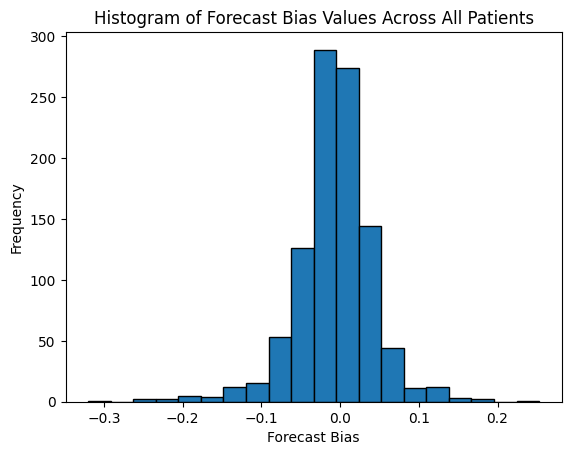

In [11]:
plt.hist(all_forecast_values, bins=20, edgecolor='black')
plt.xlabel('Forecast Bias')
plt.ylabel('Frequency')
plt.title('Histogram of Forecast Bias Values Across All Patients')
plt.show()

In [12]:
# FORECAST INTERVAL COVERAGE
def calculate_coverage(predictions_dict):
    # Dictionary to store FIC for each patient
    fic_dict = {}

    # Calculate FIC for each patient
    for key, value in predictions_dict.items():
        predictions = value['predictions']
        true_values = value['true_values']

        # Assuming you have a function to generate forecast intervals based on predictions
        forecasted_intervals = generate_forecast_intervals(predictions)

        # Calculate FIC for the current patient
        fic = calculate_coverage_for_patient(forecasted_intervals, true_values)
        
        # Store FIC in the dictionary
        fic_dict[key] = fic

    return fic_dict

def calculate_coverage_for_patient(forecasted_intervals, actual_values):
    # Calculate the number of actual values that fall within the intervals
    num_within_interval = sum((lower <= actual <= upper) for actual, (lower, upper) in zip(actual_values, forecasted_intervals))

    # Calculate the total number of observations
    total_observations = len(actual_values)

    # Calculate the coverage or FIC by dividing both values
    fic = num_within_interval / total_observations * 100

    return fic

def generate_forecast_intervals(predictions):
    # Check if predictions is a list of floats
    if all(isinstance(x, (int, float)) for x in predictions):
        return [(prediction - 0.1, prediction + 0.1) for prediction in predictions]
    # Check if predictions is a list of lists
    elif all(isinstance(x, list) and len(x) > 0 and isinstance(x[0], (int, float)) for x in predictions):
        return [(prediction[0] - 0.1, prediction[0] + 0.1) for prediction in predictions]
    else:
        raise ValueError("Predictions must be a list of floats or a list of lists with numeric values")

# Calculate FIC for each patient
fic_dict = calculate_coverage(predictions_by_patient)

In [13]:
# FIC SUMMARY STATISTICS
all_fic_values = np.array(list(fic_dict.values()))

mean_fic = np.mean(all_fic_values)
median_fic = np.median(all_fic_values)
std_fic = np.std(all_fic_values)

print(f"Mean FIC: {mean_fic:.4f}")
print(f"Median FIC: {median_fic:.4f}")
print(f"Standard Deviation of FIC: {std_fic:.4f}")

Mean FIC: 83.3458
Median FIC: 90.6977
Standard Deviation of FIC: 20.8674


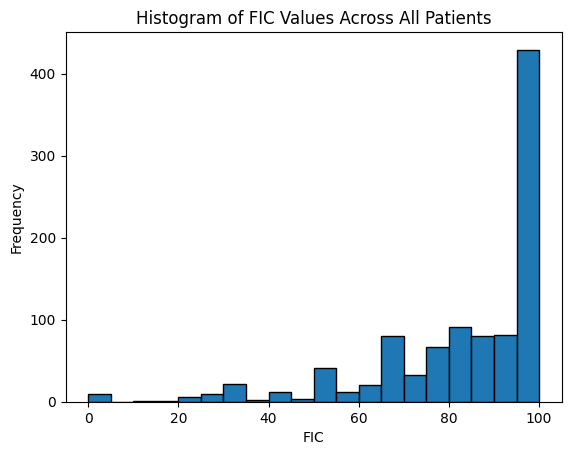

In [14]:
plt.hist(all_fic_values, bins=20, edgecolor='black')
plt.xlabel('FIC')
plt.ylabel('Frequency')
plt.title('Histogram of FIC Values Across All Patients')
plt.show()

In [15]:
# PREDICTION DIRECTION ACCURACY
def calculate_pda(predictions_dict):
    # Initialize the value of the correct directions variable
    correct_directions_total = 0
    total_directions = 0

    # Iterate through each patient in the dictionary
    for key, values in predictions_dict.items():
        # Extract predicted and true values
        predicted_values = values['predictions']
        actual_values = values['true_values']

        # Iterate each value
        for i in range(1, len(predicted_values)):
            # Calculate predicted and actual directions
            pred_change = predicted_values[i] - predicted_values[i - 1]
            actual_change = actual_values[i] - actual_values[i - 1]

            # Check if the predictions match the actual directions
            if (pred_change > 0 and actual_change > 0) or (pred_change < 0 and actual_change < 0):
                correct_directions_total += 1

            total_directions += 1

    # Calculate PDA
    pda = (correct_directions_total / total_directions) * 100
    return pda

# Calculate PDA for your dictionary
pda = calculate_pda(predictions_by_patient)
print("Prediction Direction Accuracy:", pda, '%')

Prediction Direction Accuracy: 83.51910069543679 %


## 6) PREDICTION VS TRUE VALUE PLOTS

In [16]:
filtered_rmse_dict = [key for key, values in predictions_by_patient.items() if len(values['predictions']) > 5]

In [17]:
# Get patients with more than 5 values in 'predictions'
keys_with_more_than_5_values = [key for key, values in predictions_by_patient.items() if len(values['predictions']) > 5]

# Filter rmse_dict based on the keys with more than 5 values
filtered_rmse_dict = {key: rmse_dict[key] for key in keys_with_more_than_5_values}

# Calculate the mean of means
mean_of_means = sum(rmse_dict.values()) / len(rmse_dict)

# Set a threshold for selecting keys with mean RMSE values close to the mean of means
threshold = 0.01  # Adjust this threshold as needed

# Get 4-5 keys with the maximum mean RMSE values
max_keys = sorted(filtered_rmse_dict, key=filtered_rmse_dict.get, reverse=True)[:5]

# Get 4-5 keys with the mean RMSE values close to the mean of means
average_keys = [patient_id for patient_id, mean_rmse in filtered_rmse_dict.items() if abs(mean_rmse - mean_of_means) <= threshold][:5]

# Get 4-5 keys with the minimum mean RMSE values
min_keys = sorted(filtered_rmse_dict, key=filtered_rmse_dict.get)[:5]

# Print the results
print("Keys with Maximum Mean RMSE Values:", max_keys)
print("Keys with Mean RMSE Values Close to the Mean of Means:", average_keys)
print("Keys with Minimum Mean RMSE Values:", min_keys)


Keys with Maximum Mean RMSE Values: ['659ad515', '09e8edf1', '086423b5', '07d8a24e', '1b0ec5a6']
Keys with Mean RMSE Values Close to the Mean of Means: ['003ccc87', '0073aba6', '0158a9f3', '03a87410', '04074dfe']
Keys with Minimum Mean RMSE Values: ['38ff8103', '88202e6b', '371e9dfe', '3de4002f', '088b065d']


In [18]:
dfs = {}  # Dictionary to store dataframes with patient_id as key

for patient_id in max_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

for patient_id in min_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

for patient_id in average_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

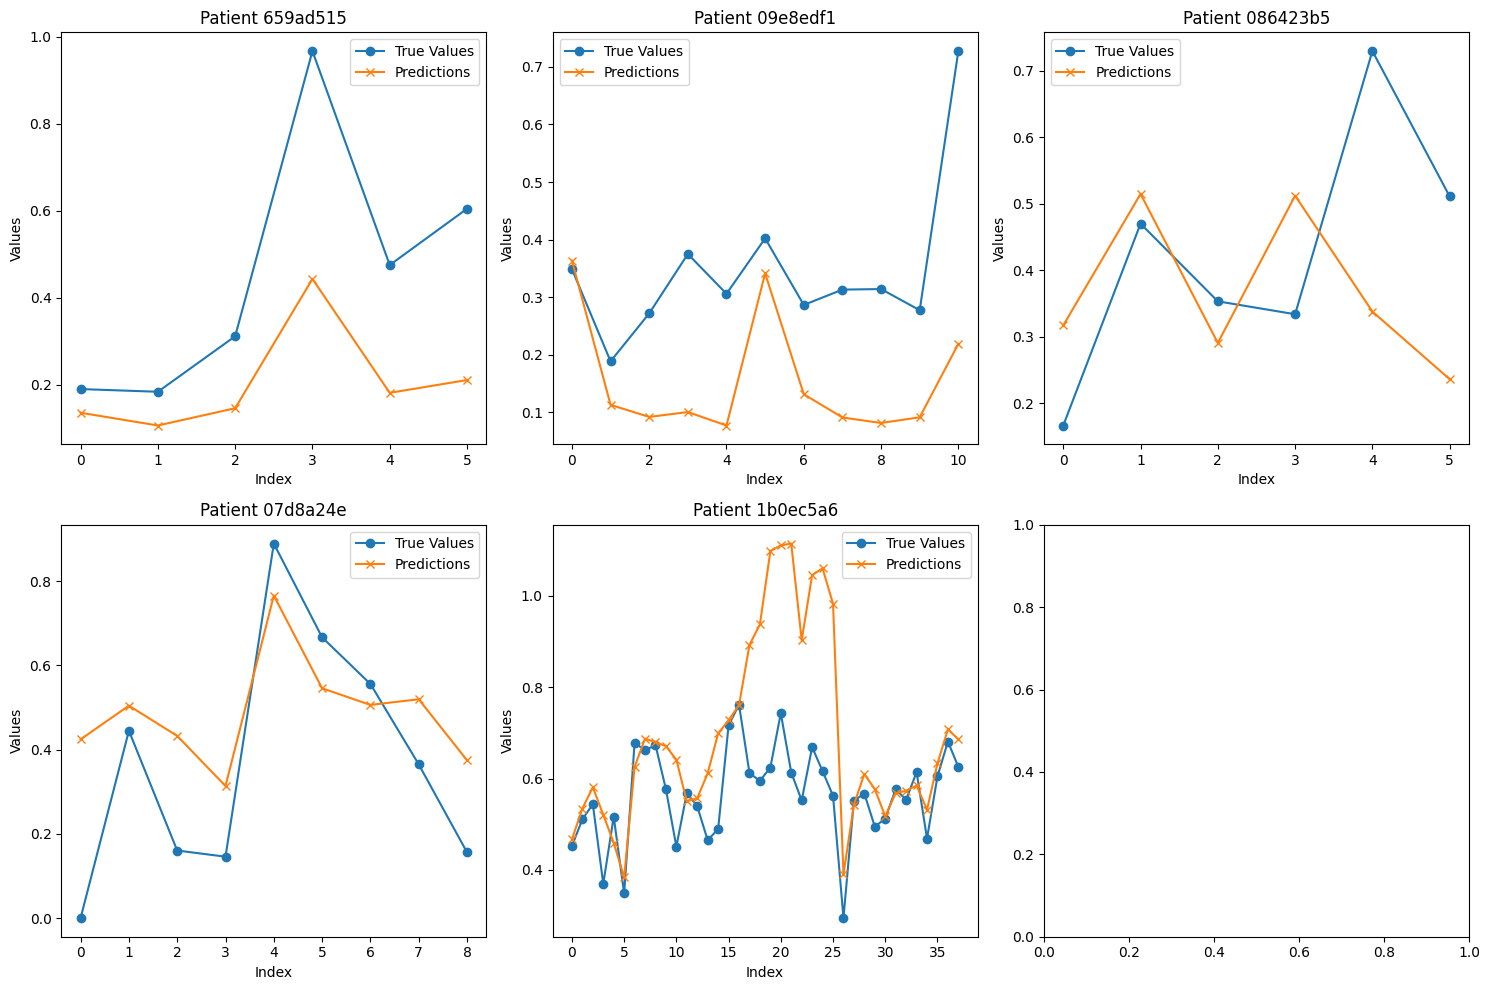

In [19]:
# WORST PREDICTIONS
selected_dfs = {patient_id: dfs[patient_id] for patient_id in max_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

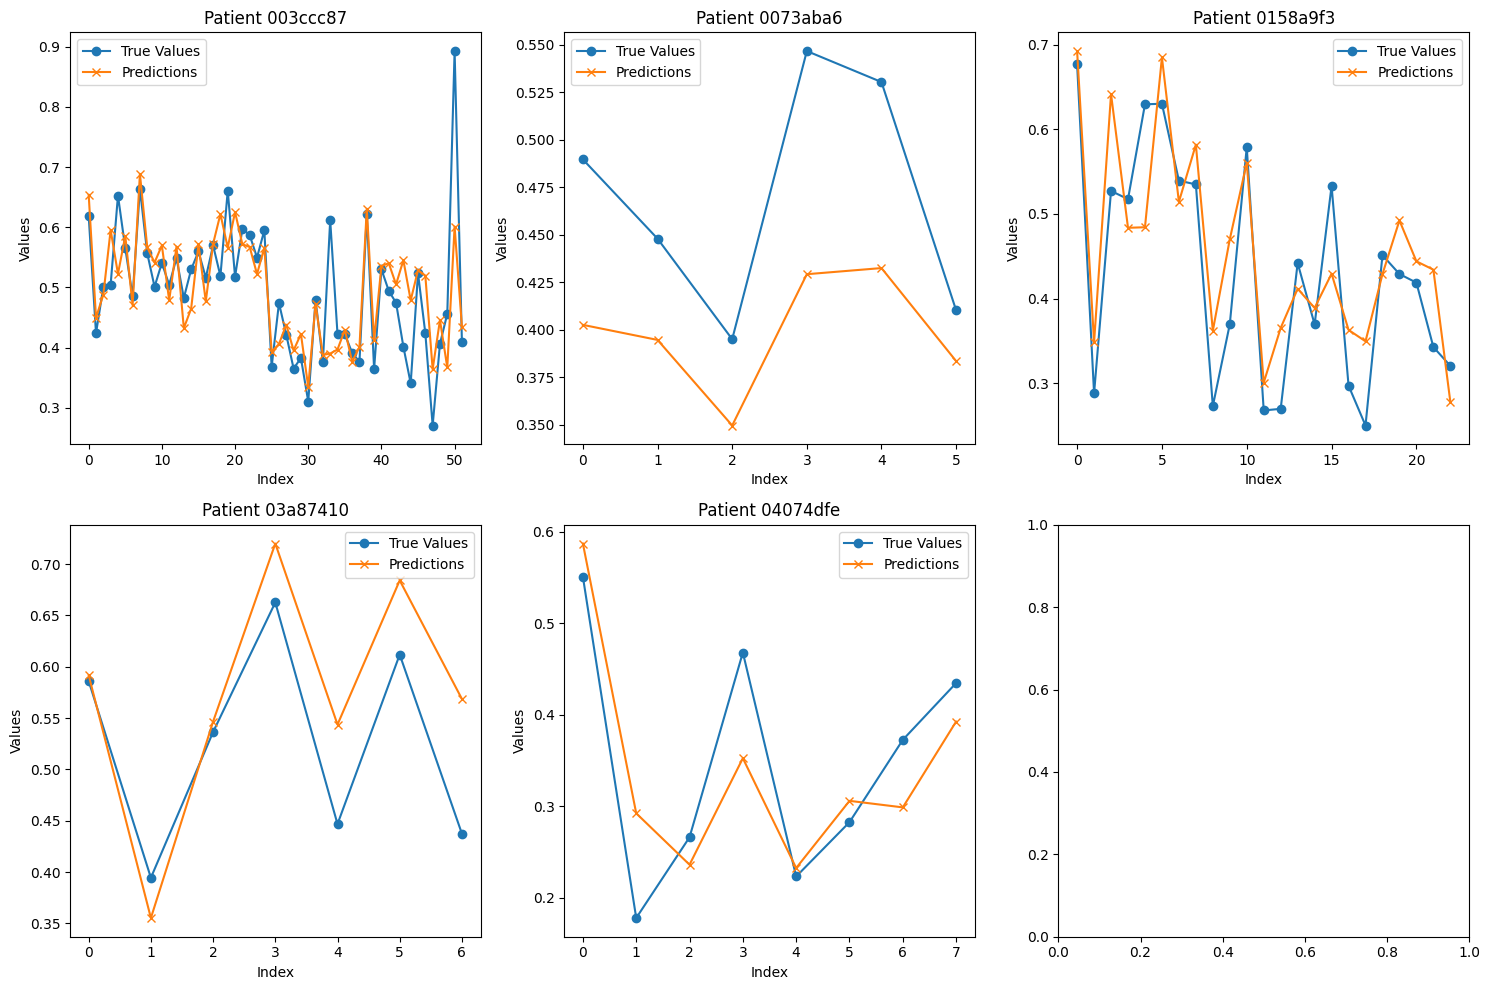

In [20]:
# AVERAGE PREDICTIONS

selected_dfs = {patient_id: dfs[patient_id] for patient_id in average_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

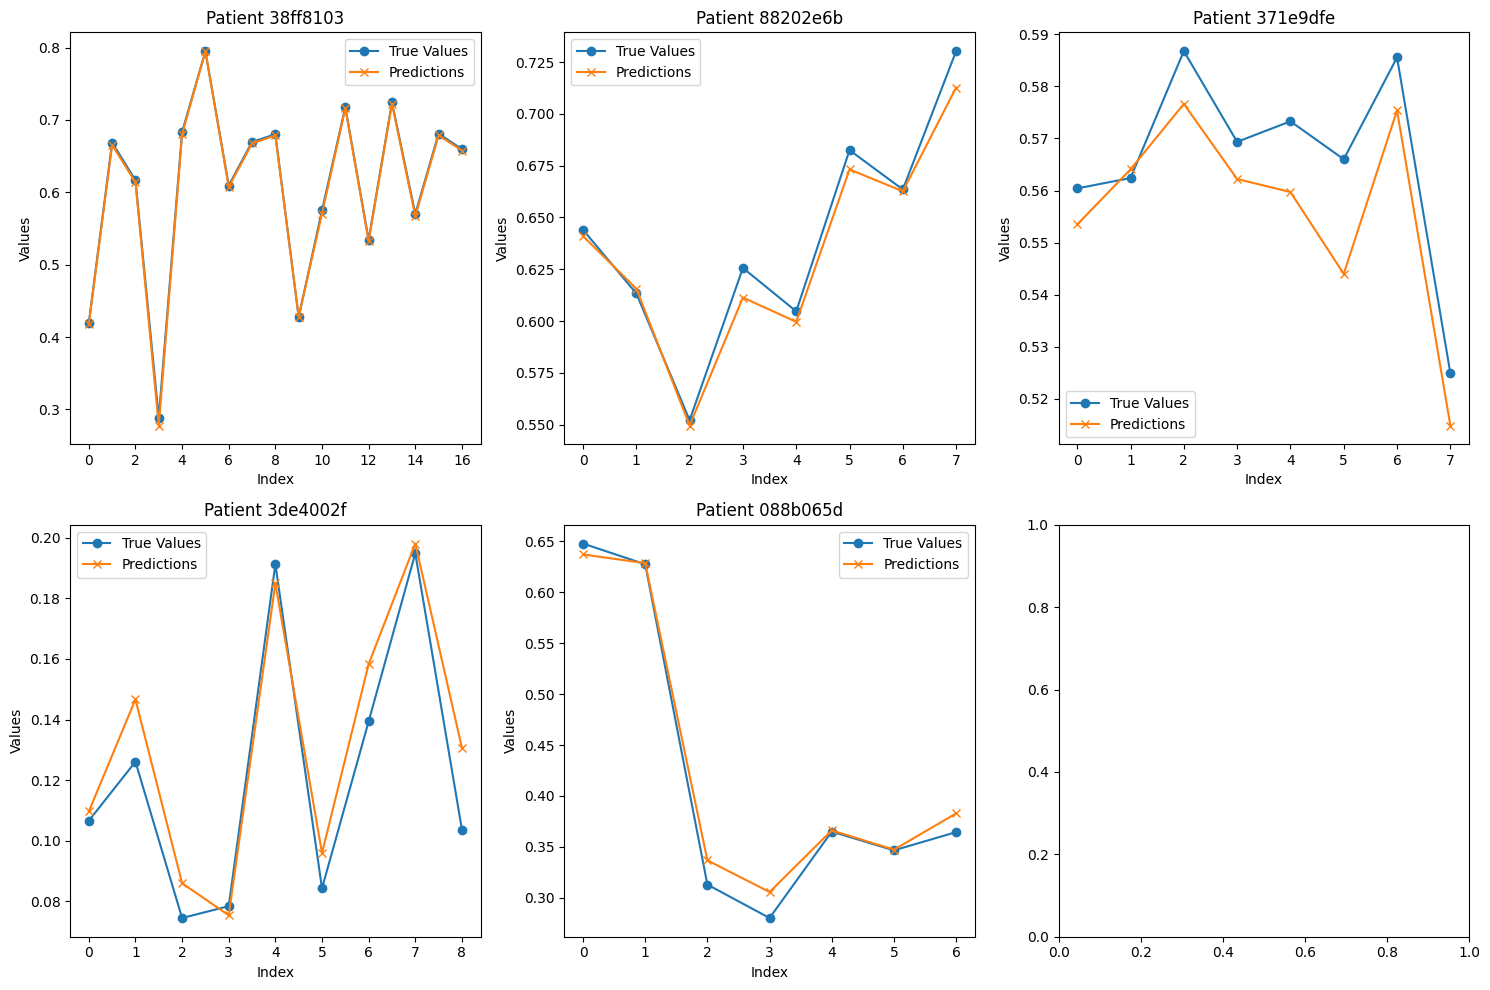

In [21]:
# BEST PREDICTIONS

selected_dfs = {patient_id: dfs[patient_id] for patient_id in min_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 7) RMSE AND REPRODUCIBILITY

    Patient      RMSE
0  b13fd4a3  0.103081
1  2cccfdd5  0.259092
2  e05868f8  0.204485
3  ce205f7b  0.173515
4  081cae65  0.132453


<Figure size 1600x600 with 0 Axes>

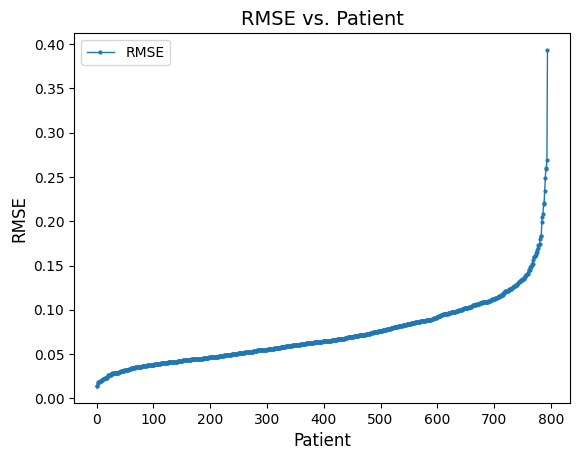

In [3]:
with open('CNN_1RMSE_predictions.json') as json_file:
    rmse_dict1 = json.load(json_file)

import matplotlib.pyplot as plt
# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict1.items()]

# Create DataFrame from the list of tuples
df1 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
print(df1.head())

df1= df1.sort_values(by="RMSE")
# df1["log"] = np.log(df1['RMSE'])
df1.reset_index(drop=True, inplace=True)

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df1.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE vs. Patient', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

<Figure size 1600x600 with 0 Axes>

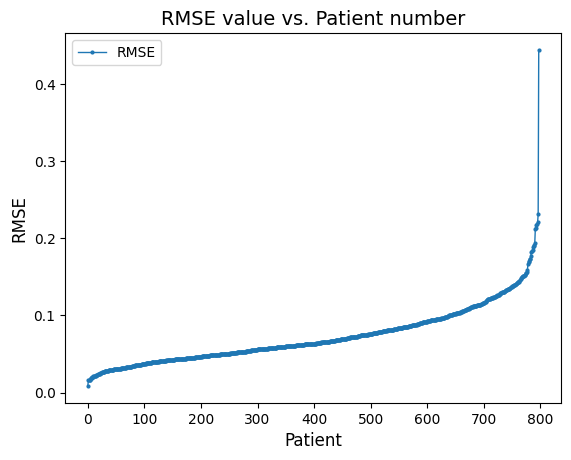

In [4]:
with open('CNN_2RMSE_predictions.json') as json_file:
    rmse_dict2 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict2.items()]

# Create DataFrame from the list of tuples
df2 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
# print(df1.head())

df2= df2.sort_values(by="RMSE")
df2.reset_index(drop=True, inplace=True)

# df2["log"] = np.log(df2['RMSE'])

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df2.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE value vs. Patient number', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

<Figure size 1600x600 with 0 Axes>

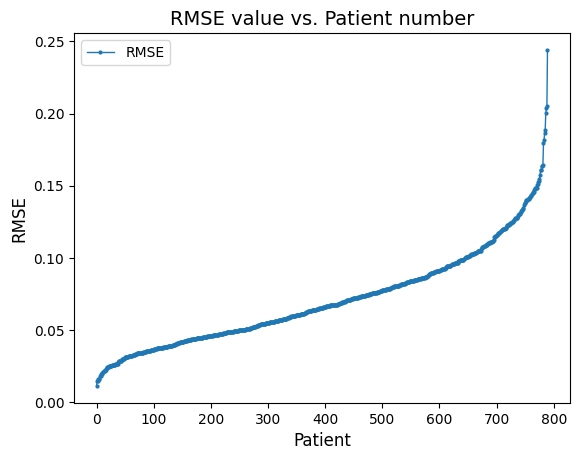

In [5]:
with open('CNN_3RMSE_predictions.json') as json_file:
    rmse_dict3 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict3.items()]

# Create DataFrame from the list of tuples
df3 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
# print(df1.head())

df3= df3.sort_values(by="RMSE")
df3.reset_index(drop=True, inplace=True)

# df3["log"] = np.log(df3['RMSE'])

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df3.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE value vs. Patient number', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

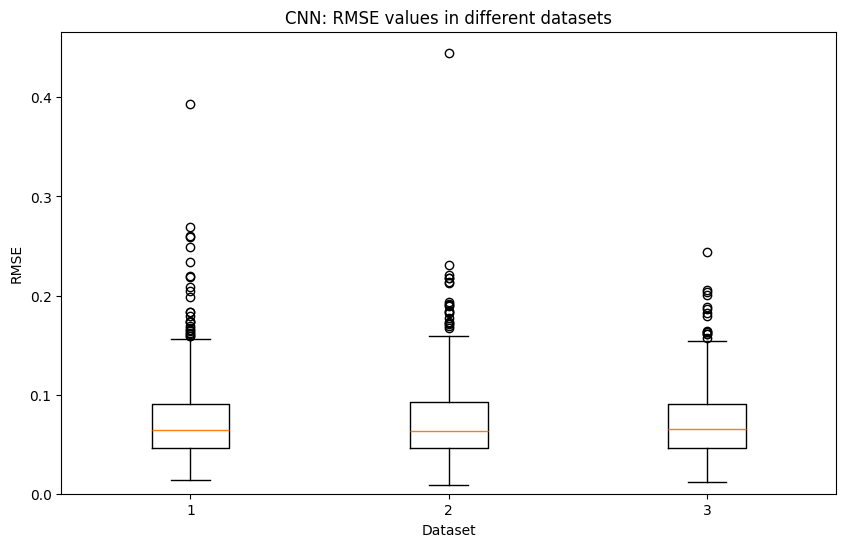

<Figure size 640x480 with 0 Axes>

In [7]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot box plots for df1, df2, and df3
plt.boxplot([df1['RMSE'], df2['RMSE'], df3['RMSE']], labels=['1', '2', '3'])

# Add title and labels
plt.title('CNN: RMSE values in different datasets')
plt.xlabel('Dataset')
plt.ylabel('RMSE')

# Set y-axis starting at 0
plt.ylim(0)

# Show plot
plt.show()

plt.savefig('Boxplot_CNN_RMSE.png')